In [1]:
import pandas as pd
import mne as mne
import os 
import time
import numpy as np
import matplotlib.pyplot as plt
import joblib
import constants
from IPython.utils import io
import time
import sys
import yasa
from scipy.signal import welch

## Use decision tree as a rough way for splitting based on that feature
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier

#Import my modules
import format_eeg_data
import constants
import eeg_stat_ts
import run_expts

from constants import regions

/user/home/ko20929/.conda/envs/sktime_latest/lib/python3.11/site-packages/antropy/fractal.py:197: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit((types.Array(types.float64, 1, "C", readonly=True), types.int32))
/user/home/ko20929/.conda/envs/sktime_latest/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package yasa is out of date. Your version is 0.6.3, the latest is 0.6.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


#### Create df_ratios dataframe

In [2]:
sys.argv[1] = 4
sys.argv[2] = 2

reduced_slide_list = [ (0.5, 0.5), (1, 0.5), (2, 0.5), (3, 0.5), (4, 0.5), (6, 0.5), (8, 0.5), (10, 1), (12, 1), (14, 1)]
super_reduced_slide_list = [ (0.5, 0.5), (1, 0.5), (2, 0.5), (4, 1), (6, 1), (8, 1), (10,1), (14, 1) ] 

In [3]:
d_num = int( sys.argv[1] )
data_type = ['N2', 'N3','REM', 'Wake', 'N1'][d_num]

expt_num = int( sys.argv[2] )

#2. Load the data based on data type ___________________________________________________________
df = joblib.load(os.path.join(os.path.abspath('..'), data_type + '_psd_normalised_data.pkl') )

single_region_df = df[[col for col in df.columns if col.endswith('_Central')]]
frequency_vals  = np.arange(0.5,40.125, 0.125)
single_region_df.columns = frequency_vals

folder = '/user/home/ko20929/work/RBD_using_custom_package/Blue_pebble/'
paths = joblib.load(folder + data_type + '_paths.pkl')

groups = pd.Series(paths['s_p_id'])
s_class_list = pd.Series(paths['s_class_list'])
y = s_class_list.map({'HC': 0 , 'PD' : 1 , 'PD+RBD' : 2 , 'RBD' : 3})

#3 Generate the frequency band search space ____________________________________________________
width_slide_list = [(0.5,0.5)] 
for window_width in range(1, 15 ):
    width_slide_list.append((window_width, 0.5) )

#4 Calculate all of the features ________________________________________________________________
feature_dfs = []

for window_width_hz, window_slide_hz in super_reduced_slide_list:
    description = 'window width : ' + str(window_width_hz) + ' .  window stride : ' + str(window_slide_hz)
    
    #1.Set Window width in Hz and Window Slide in Hz
    # window_width_hz = 3
    window_len = (window_width_hz/0.125)+1
    assert window_len%1 == 0
    window_len = int(window_len)
    
    # window_slide_hz = 0.5 
    window_slide_len = window_slide_hz/0.125 
    assert window_slide_len%1 == 0
    window_slide_len = int(window_slide_len)
    
    
    #2.Calculate band values and store in dataframe calculated_df
    
    # Start of the window is the middle_freq value minus window_width_hz/2 
    # End of the window is the middle freq value plus window_width_hz/2
    window_len
    
    middle_freq = []
    final_cols = []
    
    i = 0
    while i < len(frequency_vals) - window_len:
        middle_freq.append( frequency_vals[i:i+window_len].mean() )
        band_vals = single_region_df.iloc[:,i:i+window_len].mean(axis = 1) #For every row calculate the mean for the appropriate elements
        
        final_cols.append(band_vals)
        
        # scaled_psd.append( psd_values[i:i+factor].mean() )
        i+= window_slide_len
    
    calculated_df = pd.DataFrame(final_cols).T
    calculated_df.columns = middle_freq
    
    calculated_df.columns = [ str(col) + '_width_' + str(window_width_hz) for col in calculated_df.columns]
    
    
    #3.Calculate Information Gain Based on Features
    #Change to binary HC vs PD / PD+RBD ---> Generate expt specific X,y,groups 
    X_expt , y_expt , groups_expt, expt_info = run_expts.generate_expt_x_y_groups(calculated_df,y,groups,expt_num)

    feature_dfs.append(X_expt)
        
#5 Concatenate all feature_dfs into a single dataframe_________________________________________________________________
X_expt_concatenated = pd.concat(feature_dfs, axis=1)


# cols_list = list(X_expt_concatenated.columns)

# col_combos = []
# for col_1 in cols_list:
#     ind = cols_list.index(col_1)
#     for col_2 in cols_list[ind+1:]:
#         col_combos.append([ col_1 , col_2 ] )

# scores = []
# for col_combo in col_combos: 
#     X_selected = X_expt_concatenated[ col_combo ]
#     # clf = RidgeClassifier().fit(X_selected, y_expt)
#     clf = LinearDiscriminantAnalysis().fit(X_selected, y_expt)
#     score = accuracy_score(y_expt,  clf.predict(X_selected))
#     scores.append(score)

In [4]:
calculated_cols = []
col_names = []

X_expt_ratios = X_expt_concatenated.copy() 

for col_1 in X_expt_concatenated.columns:
    for col_2 in X_expt_concatenated.columns:
        if col_1 == col_2:
            pass
        else:
            new_col = col_1 + '/' + col_2  
            col_names.append(new_col)
            calculated_cols.append( X_expt_concatenated[col_1]/X_expt_concatenated[col_2] )

In [10]:
(388*388) - 388
# combined_feats = pd.concat([df_ratios, df_ratios])

150156

In [5]:
df_ratios = pd.concat(calculated_cols, axis = 1)
df_ratios.columns = col_names
df_ratios.head(5)

,0.75_width_0.5/1.25_width_0.5,0.75_width_0.5/1.75_width_0.5,0.75_width_0.5/2.25_width_0.5,0.75_width_0.5/2.75_width_0.5,0.75_width_0.5/3.25_width_0.5,0.75_width_0.5/3.75_width_0.5,0.75_width_0.5/4.25_width_0.5,0.75_width_0.5/4.75_width_0.5,0.75_width_0.5/5.25_width_0.5,0.75_width_0.5/5.75_width_0.5,...,32.5_width_14/22.5_width_14,32.5_width_14/23.5_width_14,32.5_width_14/24.5_width_14,32.5_width_14/25.5_width_14,32.5_width_14/26.5_width_14,32.5_width_14/27.5_width_14,32.5_width_14/28.5_width_14,32.5_width_14/29.5_width_14,32.5_width_14/30.5_width_14,32.5_width_14/31.5_width_14
0,1.794553,2.756616,3.681535,4.158527,5.059160,4.984261,5.693642,5.262839,4.783447,4.079915,...,0.441925,0.491615,0.541055,0.600232,0.663672,0.717631,0.770162,0.823792,0.879385,0.937030
1,1.794402,2.506041,3.100032,3.188955,3.968719,4.164938,4.215504,4.598409,4.516207,4.804294,...,0.495656,0.539148,0.586940,0.635755,0.687063,0.731928,0.774122,0.827194,0.879223,0.937242
2,2.366022,3.940456,4.360234,5.180982,5.984576,6.750074,6.521544,6.583080,6.822519,6.098148,...,0.260177,0.308545,0.365178,0.428384,0.497853,0.578744,0.658643,0.743317,0.831322,0.916571
3,1.957830,2.962536,3.376577,4.298293,4.871717,5.206577,6.113044,6.158187,7.141282,6.210752,...,0.340807,0.380364,0.418511,0.463483,0.514277,0.578463,0.645728,0.721719,0.806209,0.899720
4,1.351155,2.171596,2.901544,4.060360,4.299390,4.309898,4.408894,4.217316,3.590405,3.991870,...,0.282506,0.317973,0.359183,0.403371,0.458706,0.513293,0.589100,0.668976,0.764118,0.877782


In [227]:
pd.concat([df_ratios, X_expt_concatenated])

,0.75_width_0.5/1.25_width_0.5,0.75_width_0.5/1.75_width_0.5,0.75_width_0.5/2.25_width_0.5,0.75_width_0.5/2.75_width_0.5,0.75_width_0.5/3.25_width_0.5,0.75_width_0.5/3.75_width_0.5,0.75_width_0.5/4.25_width_0.5,0.75_width_0.5/4.75_width_0.5,0.75_width_0.5/5.25_width_0.5,0.75_width_0.5/5.75_width_0.5,...,23.5_width_14,24.5_width_14,25.5_width_14,26.5_width_14,27.5_width_14,28.5_width_14,29.5_width_14,30.5_width_14,31.5_width_14,32.5_width_14
0,1.794553,2.756616,3.681535,4.158527,5.059160,4.984261,5.693642,5.262839,4.783447,4.079915,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.794402,2.506041,3.100032,3.188955,3.968719,4.164938,4.215504,4.598409,4.516207,4.804294,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.366022,3.940456,4.360234,5.180982,5.984576,6.750074,6.521544,6.583080,6.822519,6.098148,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.957830,2.962536,3.376577,4.298293,4.871717,5.206577,6.113044,6.158187,7.141282,6.210752,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.351155,2.171596,2.901544,4.060360,4.299390,4.309898,4.408894,4.217316,3.590405,3.991870,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000596,0.000488,0.000396,0.000318,0.000261,0.000218,0.000186,0.000161,0.000143,0.000128
67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.001437,0.001395,0.001356,0.001327,0.001286,0.001237,0.001176,0.001101,0.001014,0.000923
68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.002682,0.002617,0.002539,0.002448,0.002339,0.002194,0.002006,0.001781,0.001561,0.001359
69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000594,0.000519,0.000443,0.000382,0.000330,0.000282,0.000243,0.000210,0.000181,0.000160


#### Run test experiments

##### Randomize y labels

In [94]:
y_r = y_expt.copy()
zero_indices = y_r[y_r == 0].sample(frac=0.55).index
y_r.loc[zero_indices] = 1

one_indices = y_r[y_r == 1].sample(frac=0.4).index
y_r.loc[one_indices] = 0

y_r.value_counts()

0    26
1    22
Name: count, dtype: int64

##### Run test experiments

In [7]:
for i in range(3):
    DT = DecisionTreeClassifier(max_depth=2)
    DT.fit(pd.concat([df_ratios, X_expt_concatenated], axis = 1) , y_expt)
    score = accuracy_score(y_expt,  DT.predict(pd.concat([df_ratios, X_expt_concatenated],axis = 1)) )
    print(score)

0.9148936170212766
0.9148936170212766
0.9148936170212766


In [235]:
for i in range(3):
    RF = RandomForestClassifier(n_estimators=100, max_depth = 2)
    RF.fit(pd.concat([df_ratios, X_expt_concatenated],axis = 1), y_expt)
    score = accuracy_score(y_expt,  RF.predict(pd.concat([df_ratios, X_expt_concatenated],axis = 1)) )
    print(score)

1.0
0.9574468085106383
0.9787234042553191


In [236]:
concated_df = pd.concat([df_ratios, X_expt_concatenated],axis = 1)

In [152]:
from sklearn.ensemble import AdaBoostClassifier

In [194]:
from sklearn.svm import SVC

In [ ]:
#AdaBoost classifier does great with about 15 trees !! 

In [216]:
clf = DecisionTreeClassifier(max_depth = 3)
clf = AdaBoostClassifier(n_estimators = 20)
# clf = SVC(kernel = 'linear', degree = 2)
clf_dict = {'RF' : clf}

In [237]:
regional_features_dict = {'all_feats' : list( concated_df.columns ) } 

In [238]:
t1 = time.time()
results_df = run_expts.run_mv_tsc(concated_df,y_expt,groups_expt, clf_dict , return_df = True , subset_names_and_cols = regional_features_dict, random_states = [1] )
res_df = run_expts.generate_subset_acc_std(results_df, return_df = True)
display(res_df)
t2 = time.time()
t2 - t1

,random_state,all_feats_RF_acc,all_feats_RF_std
0,1,0.471111,0.175766


70.37058544158936

In [239]:
res_df

,random_state,all_feats_RF_acc,all_feats_RF_std
0,1,0.471111,0.175766


#### Plot trees and do scatter plot

[Text(0.6, 0.8333333333333334, 'x[21804] <= 0.989\ngini = 0.498\nsamples = 47\nvalue = [25, 22]'),
 Text(0.4, 0.5, 'x[140329] <= 1.88\ngini = 0.43\nsamples = 32\nvalue = [10, 22]'),
 Text(0.2, 0.16666666666666666, 'gini = 0.26\nsamples = 26\nvalue = [4, 22]'),
 Text(0.6, 0.16666666666666666, 'gini = 0.0\nsamples = 6\nvalue = [6, 0]'),
 Text(0.8, 0.5, 'gini = 0.0\nsamples = 15\nvalue = [15, 0]')]

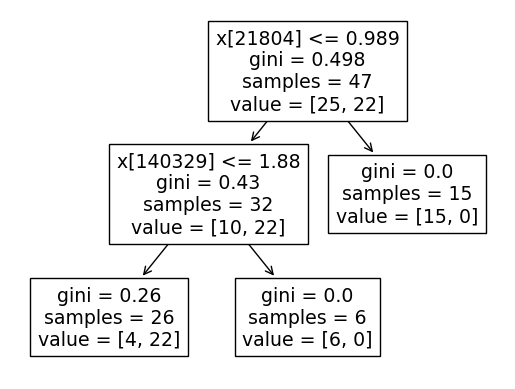

In [8]:
plot_tree(DT, feature_names = list( df_ratios.columns ) )
plot_tree(DT)

Text(0, 0.5, '24.5_width_6/23.25_width_0.5')

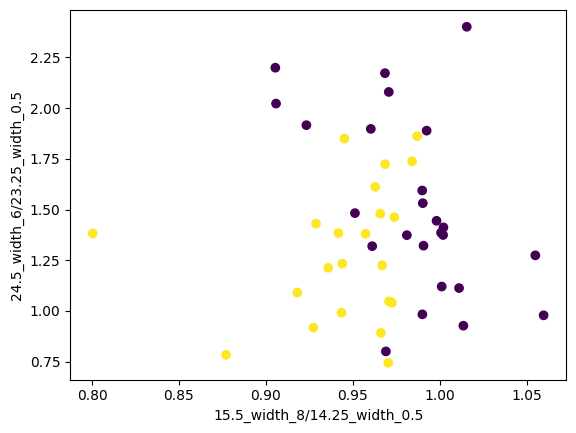

In [10]:
plt.scatter( df_ratios.iloc[: , 21804] ,df_ratios.iloc[:, 140329] , c = y_expt.values)
# plt.plot( [0.663, 0.663] , [0.84,0.96] , c = 'b')
# plt.plot( [0.4, 1.55] , [0.879, 0.879] , c = 'b')
# plt.xlim(0.4, 1.55)
# plt.ylim(0.84, 0.96)
plt.xlabel(df_ratios.columns[120384])
plt.ylabel(df_ratios.columns[111114])